## <center>Part 3: Modeling </center>

### Table of Contents

1. [Introduction](#Introduction)
    <br>
        
2. [Baseline Modeling - Logistic Regression](#Baseline-Modeling---Logistic-Regression)
   - [CountVectorizer using custom tokenizer - Lemmatization](#CountVectorizer-using-custom-tokenizer---Lemmatization)
   - [CountVectorizer using custom tokenizer - Stemming](#CountVectorizer-using-custom-tokenizer---Stemming)
   - [TF-IDF using custom tokenizer - Lemmatization](#TF-IDF-using-custom-tokenizer---Lemmatization)
   - [TF-IDF using custom tokenizer - Stemmer](#TF-IDF-using-custom-tokenizer---Stemmer)
   - [Hyper-parameter tuning on TF-IDF](#Hyper-parameter-tuning-on-TF-IDF)
   - [Addressing class imbalance](#Addressing-class-imbalance)
   - [Word Embedding Techniques](#Word-Embedding-Techniques)
   - [Hyperparameter tuning on sentence2vec embedding](#Hyperparameter-tuning-on-sentence2vec-embedding)
   
     <br>
       
3. [Naive-Bayes Classifier](#Naive-Bayes-Classifier)
   - [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
   - [Complement Naive-Bayes](#Complement-Naive-Bayes)
   - [Grid search on complementNB()](#Grid-search-on-complementNB)

     <br>

4. [Support Vector Classifier](#Support-Vector-Classifier)
   - [LinearSVC](#LinearSVC)
   - [Hyper-parameter tuning on LinearSVC](#Hyper-parameter-tuning-on-LinearSVC)
   - [SVC (linear kernel)](#SVC-(linear-kernel))

     <br>

5. [Model Evaluations and Selection](#Model-Evaluations-and-Selection)
   - [Evaluation Metric: Accuracy vs. F1 Score](#Evaluation-Metric:-Accuracy-vs.-F1-Score)
   - [Model Selection](#Model-Selection)
   
     <br>

6. [Summary](#Summary)


## Introduction

In this part, we will apply the knowledge we've gained from data cleaning, exploratory data analysis (EDA), and pre-processing as we dive into model creation. Our journey begins with constructing a baseline model to predict article categories based on the article text. From there, we will proceed with fine-tuning hyperparameters to see how they impact model performance. Also, we will examine different classification models, assess their performance, and make comparisons based on accuracy.

As our first step, we will import the necessary libraries and packages.

In [1]:
# Importing necessary libraries and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE

from my_functions import lem_tokenizer, stem_tokenizer, remove_html_tags, ENGLISH_STOP_WORDS, sentence2vec #importing custom functions that I have created

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
import time

from sklearn.svm import SVC

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adhit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adhit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reading the data from the preprocessed categories csv file and writing it into a dataframe

df_categories = pd.read_csv('preprocessed_categories.csv')


# Setting the index to begin from 1
df_categories.reset_index(drop=True, inplace=True)
df_categories.index += 1

Let's have our first look into our dataset:

In [3]:
# Sanity check

df_categories.head(10)

,link,headline,category,short_description,authors,date,month_num,year,article_text
1,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,WORLD NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,9,2022,Over 4 Million Americans Roll Up Sleeves For O...
2,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",WORLD NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,9,2022,"American Airlines Flyer Charged, Banned For Li..."
3,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,9,2022,23 Of The Funniest Tweets About Cats And Dogs ...
4,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,9,2022,The Funniest Tweets From Parents This Week (Se...
5,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,WORLD NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,9,2022,Woman Who Called Cops On Black Bird-Watcher Lo...
6,https://www.huffpost.com/entry/belk-worker-fou...,Cleaner Was Dead In Belk Bathroom For 4 Days B...,WORLD NEWS,The 63-year-old woman was seen working at the ...,NaN,2022-09-22,9,2022,Cleaner Was Dead In Belk Bathroom For 4 Days B...
7,https://www.huffpost.com/entry/reporter-gets-a...,Reporter Gets Adorable Surprise From Her Boyfr...,WORLD NEWS,"""Who's that behind you?"" an anchor for New Yor...",Elyse Wanshel,2022-09-22,9,2022,Reporter Gets Adorable Surprise From Her Boyfr...
8,https://www.huffpost.com/entry/puerto-rico-wat...,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...,"DÁNICA COTO, AP",2022-09-22,9,2022,Puerto Ricans Desperate For Water After Hurric...
9,https://www.huffpost.com/entry/mija-documentar...,How A New Documentary Captures The Complexity ...,ARTS & CULTURE,"In ""Mija,"" director Isabel Castro combined mus...",Marina Fang,2022-09-22,9,2022,How A New Documentary Captures The Complexity ...
10,https://www.huffpost.com/entry/biden-un-russia...,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...,"Aamer Madhani, AP",2022-09-21,9,2022,Biden At UN To Call Russian War An Affront To ...


In [4]:
# Sanity check
df_categories.shape

(189801, 9)

In [5]:
# Checking number of unique categories after combining similar categories
df_categories.groupby("category").ngroups

22

#### Target Label Embedding

Given that we have 22 target categories, we can proceed to convert them into numerical values using a label encoder, assigning a unique numerical identifier to each category.

In [52]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df_categories["category_encoded"] = label_encoder.fit_transform(df_categories["category"])


In [7]:
# Create a DataFrame for the mapping table
category_mapping = pd.DataFrame({
    "Encoded Value": df_categories["category_encoded"].unique(),
    "Category Name": label_encoder.inverse_transform(df_categories["category_encoded"].unique())
})


# Display category mapping table
category_mapping

,Encoded Value,Category Name
0,21,WORLD NEWS
1,2,COMEDY
2,11,PARENTING
3,0,ARTS & CULTURE
4,14,SCIENCE & TECH
5,15,SPORTS
6,5,ENTERTAINMENT
7,12,POLITICS
8,6,ENVIRONMENT
9,4,EDUCATION


For example, "World News" is mapped to 21; "Comedy" is mapped to 2; "Parenting" is mapped to 11 and so on.

Based on the domain knowledge, we can confirm that the 'article_text' column, generated by merging the 'headline' and 'short_description' columns, will play a pivotal role in predicting the target category labels. With that, we will proceed to create Train/Test split 

#### Train/Test Split

We would do a 80/20 split maintaining the same proportion of each target labels in both train and test sets to avoid any bias in our data. Additionally, using the same training and test datasets consistently across different models and hyperparameters enhances the robustness of our model-building process.

In [10]:
# Split the data into training and testing sets
X = df_categories["article_text"]  # Input feature (article text)
y = df_categories["category_encoded"]  # Target variable (categories)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Baseline Modeling - Logistic Regression

We will initiate our modeling process with a basic classifier, namely logistic regression, to set the initial performance benchmark. This benchmark indicates the lowest achievable accuracy without any hyperparameter tuning.

### CountVectorizer using custom tokenizer - Lemmatization

When it comes to configuring the maximum number of features, we can opt for 25,000, which is a commonly recommended practice. This choice aligns with the guidance provided in this [Google article](https://developers.google.com/machine-learning/guides/text-classification/step-3)


In [23]:

# Using LEM_TOKENIZER
countvect_lem = CountVectorizer(min_df=5, 
                             tokenizer=lem_tokenizer, max_features=25000, ngram_range=(1,2))
countvect_lem.fit(X_train)

X_train_transformed_lem = countvect_lem.transform(X_train)
X_test_transformed_lem = countvect_lem.transform(X_test)

# Fitting a model
logreg = LogisticRegression()
logreg.fit(X_train_transformed_lem, y_train)

# Make predictions on the test data
y_pred_lem = logreg.predict(X_test_transformed_lem)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed_lem, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed_lem, y_test)}")



C:\Users\adhit\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train score: 0.9063487881981033
Test score: 0.664128974473802


C:\Users\adhit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
# Calculate accuracy and other metrics
accuracy_lem = accuracy_score(y_test, y_pred_lem)
classification_rep_lem = classification_report(y_test, y_pred_lem)
confusion_mat_lem = confusion_matrix(y_test, y_pred_lem)

# Print accuracy and classification report
print("Accuracy:", accuracy_lem)
print("\nClassification Report:\n", classification_rep_lem)



Accuracy: 0.664128974473802

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.44      0.49       653
           1       0.56      0.52      0.54      1378
           2       0.55      0.45      0.49       928
           3       0.54      0.46      0.50       566
           4       0.50      0.38      0.43       365
           5       0.61      0.66      0.63      3436
           6       0.52      0.44      0.48       697
           7       0.76      0.79      0.78      1654
           8       0.60      0.56      0.58      2161
           9       0.76      0.70      0.73       863
          10       0.32      0.19      0.24       416
          11       0.67      0.69      0.68      2469
          12       0.73      0.80      0.76      6488
          13       0.52      0.39      0.44       376
          14       0.54      0.46      0.50       780
          15       0.69      0.64      0.67       883
          16       0.79     

A train score of 90.6% and a test score of 66.4% indicate that the model is overfitting, meaning it captured noise in the training data but doesn't generalize well to the test data.

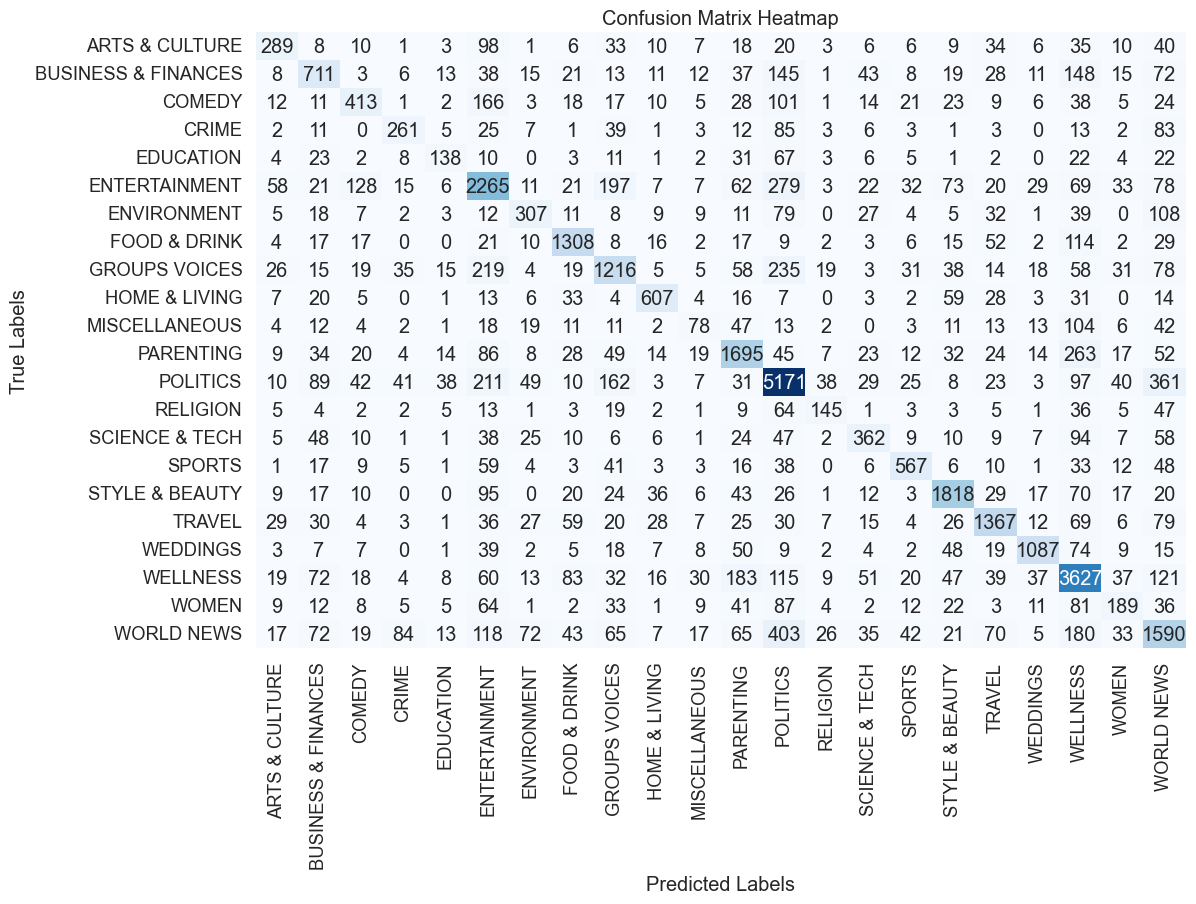

In [34]:
# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion_mat_lem, columns=label_encoder.classes_, index=label_encoder.classes_)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The confusion matrix shows the comparison between True labels vs Predicted labels. It further emphasizes that our dataset exhibits an imbalance, with a significant skew towards the "Politics" category.

### Accuracy vs F1 score: 

In our business context, **accuracy** remains pertinent because misclassifying target labels may be tolerable, considering it's not highly critical. Therefore, we can definitely incorporate the **F1 score** in the project's future scope, where the goal would be to minimize misclassifications between the "good" and "bad" categories.


Now, let's utilize stemming as the tokenization method with CountVectorizer so that we can assess its impact on model performance and compare it to previous results.

### CountVectorizer using custom tokenizer - Stemming

In [36]:
# Using CountVectorizer with Stem Tokenizer
countvect_stem = CountVectorizer(min_df=5, 
                             tokenizer=stem_tokenizer, max_features=25000, ngram_range=(1,2))
countvect_stem.fit(X_train)

X_train_transformed_stem = countvect_stem.transform(X_train)
X_test_transformed_stem = countvect_stem.transform(X_test)

# Fitting a model
logreg_stem = LogisticRegression()
logreg_stem.fit(X_train_transformed_stem, y_train)

# Make predictions on the test data
y_pred_stem = logreg_stem.predict(X_test_transformed_stem)

# Training and test score
print(f"Train score (CountVectorizer with Stem): {logreg_stem.score(X_train_transformed_stem, y_train)}")
print(f"Test score (CountVectorizer with Stem): {logreg_stem.score(X_test_transformed_stem, y_test)}")


C:\Users\adhit\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train score (CountVectorizer with Stem): 0.8971548998946259
Test score (CountVectorizer with Stem): 0.6655251442269697


C:\Users\adhit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
# Calculate accuracy and other metrics
accuracy_stem = accuracy_score(y_test, y_pred_stem)
classification_rep_stem = classification_report(y_test, y_pred_stem)

# Print the results
print("Accuracy (CountVectorizer with Stem):", accuracy_stem)
print("\nClassification Report (CountVectorizer with Stem):\n", classification_rep_stem)

Accuracy (CountVectorizer with Stem): 0.6655251442269697

Classification Report (CountVectorizer with Stem):
               precision    recall  f1-score   support

           0       0.52      0.44      0.47       653
           1       0.57      0.53      0.55      1378
           2       0.56      0.44      0.49       928
           3       0.52      0.44      0.48       566
           4       0.49      0.43      0.46       365
           5       0.62      0.66      0.63      3436
           6       0.53      0.45      0.49       697
           7       0.76      0.80      0.78      1654
           8       0.60      0.57      0.58      2161
           9       0.75      0.69      0.72       863
          10       0.33      0.19      0.25       416
          11       0.66      0.69      0.68      2469
          12       0.74      0.80      0.77      6488
          13       0.53      0.38      0.44       376
          14       0.55      0.47      0.51       780
          15       0.68  

Once again, we observe a train score of 89.7% and a test score of 66.5%, indicating potential overfitting and the necessity for hyperparameter tuning. However, before diving into that, let's explore the TF-IDF vectorizer since its vectorization methodology is different.

### TF-IDF using custom tokenizer - Lemmatization

In [49]:
# Convert short descriptions to numerical features using TF-IDF vectorization

# USING LEM_TOKENIZER
tfidf_vectorizer_lem = TfidfVectorizer(tokenizer=lem_tokenizer, max_features=25000, ngram_range=(1,3))
X_train_tfidf_lem = tfidf_vectorizer_lem.fit_transform(X_train)
X_test_tfidf_lem = tfidf_vectorizer_lem.transform(X_test)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier on the training data
classifier.fit(X_train_tfidf_lem, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_tfidf_lem)

# Training and test score
print(f"Train score (tf_idf_lem): {classifier.score(X_train_tfidf_lem, y_train)}")
print(f"Test score (tf_idf_lem): {classifier.score(X_test_tfidf_lem, y_test)}")


C:\Users\adhit\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train score (tf_idf_lem): 0.7586801896733404
Test score (tf_idf_lem): 0.6845446642606886


In [12]:
# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.6845446642606886

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.41      0.50       653
           1       0.62      0.55      0.58      1378
           2       0.68      0.41      0.51       928
           3       0.59      0.44      0.51       566
           4       0.54      0.36      0.43       365
           5       0.61      0.71      0.66      3436
           6       0.57      0.42      0.48       697
           7       0.79      0.80      0.80      1654
           8       0.66      0.53      0.59      2161
           9       0.80      0.68      0.74       863
          10       0.58      0.10      0.17       416
          11       0.67      0.74      0.70      2469
          12       0.73      0.84      0.78      6488
          13       0.62      0.34      0.44       376
          14       0.65      0.43      0.52       780
          15       0.73      0.64      0.68       883
          16       0.79    

With TF-IDF and our custom Lemmatization tokenizer approach, we achieved an impressive **75.8% train accuracy** and **68.44% test accuracy**, making it our best-performing model so far. However, we'll also explore TF-IDF with Stemming to see if we can further improve our results

### TF-IDF using custom tokenizer - Stemmer

In [43]:
# Convert short descriptions to numerical features using TF-IDF vectorization

# USING STEM_TOKENIZER
tfidf_vectorizer = TfidfVectorizer(tokenizer=stem_tokenizer, max_features=25000, ngram_range=(1,3))
X_train_tfidf_stem = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf_stem = tfidf_vectorizer.transform(X_test)

# Create a logistic regression classifier
classifier_stem = LogisticRegression(max_iter=1000)

# Train the classifier on the training data
classifier_stem.fit(X_train_tfidf_stem, y_train)

# Make predictions on the test data
y_pred_stem = classifier_stem.predict(X_test_tfidf_stem)

# Training and test score
print(f"Train score (TF-IDF with Stemming): {classifier_stem.score(X_train_tfidf_stem, y_train)}")
print(f"Test score (TF-IDF with Stemming): {classifier_stem.score(X_test_tfidf_stem, y_test)}")


C:\Users\adhit\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train score (TF-IDF with Stemming): 0.7574947312961011
Test score (TF-IDF with Stemming): 0.6859408340138563


In [44]:
# Calculate accuracy and other metrics
accuracy_stem = accuracy_score(y_test, y_pred_stem)
classification_rep_stem = classification_report(y_test, y_pred_stem)

# Print the results
print("Accuracy (TF-IDF with Stemming):", accuracy_stem)
print("\nClassification Report (TF-IDF with Stemming):\n", classification_rep_stem)

Accuracy (TF-IDF with Stemming): 0.6859408340138563

Classification Report (TF-IDF with Stemming):
               precision    recall  f1-score   support

           0       0.63      0.41      0.50       653
           1       0.62      0.54      0.58      1378
           2       0.68      0.41      0.51       928
           3       0.60      0.43      0.50       566
           4       0.56      0.36      0.44       365
           5       0.61      0.71      0.66      3436
           6       0.56      0.43      0.49       697
           7       0.79      0.80      0.80      1654
           8       0.66      0.53      0.59      2161
           9       0.81      0.68      0.74       863
          10       0.59      0.10      0.17       416
          11       0.68      0.74      0.71      2469
          12       0.73      0.83      0.78      6488
          13       0.62      0.36      0.46       376
          14       0.64      0.44      0.52       780
          15       0.71      0.63  

When employing TF-IDF with the Stemming tokenizer, our model exhibited a train accuracy score of 75.75%. And the **test accuracy score was 68.59%**, indicating that the model achieved accurate predictions for approximately 68.59% of the previously unseen test data.

Since both tokenizers (Stemming and Lemmatization) with TF-IDF vectorizer resulted in a test accuracy of 68.5%, we can proceed to fine tune our hyper-parameters in the following sections.

### Hyper-parameter tuning on TF-IDF

#### (i) using X_train_tfidf from Tokenizer - Stemmer

C:\Users\adhit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


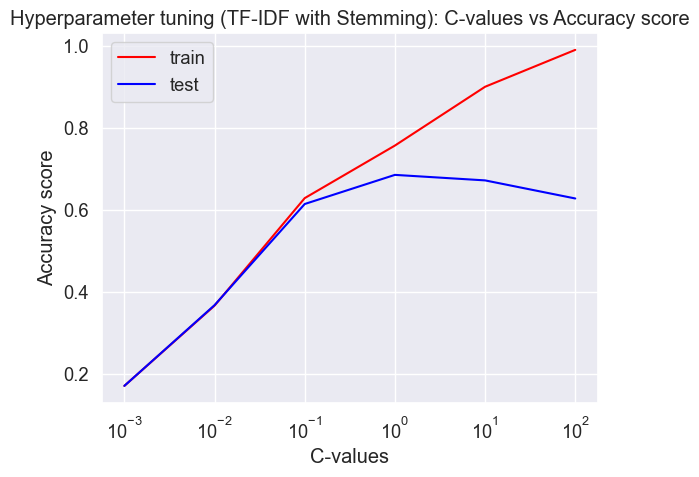

In [47]:
# C_values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Empty lists to append train and test accuracy scores to
train_acc_hyper_stem = []
test_acc_hyper_stem = []

# Loop through the different C values
for C in C_values:

    
    logit_stem = LogisticRegression(C=C, random_state=42, max_iter=1000)

  
    logit_stem.fit(X_train_tfidf_stem, y_train)

    # Score the model
    train_acc_hyper_stem.append(logit_stem.score(X_train_tfidf_stem, y_train))
    test_acc_hyper_stem.append(logit_stem.score(X_test_tfidf_stem, y_test))

# Plotting
plt.figure()
plt.plot(C_values, train_acc_hyper_stem, c='red', label='train')
plt.plot(C_values, test_acc_hyper_stem, c='blue', label='test')
plt.xscale('log')
plt.xlabel('C-values')
plt.ylabel('Accuracy score')
plt.title('Hyperparameter tuning (TF-IDF with Stemming): C-values vs Accuracy score')
plt.legend()
plt.show()


As per the graph above, we can conclude that C=1 is the model with the best fit. 

Let's try the same with TF-IDF Lemmatization combination to see if there is any improvement in the model performance.

#### (ii) using X_train_tfidf from Tokenizer - Lemmatization

C:\Users\adhit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


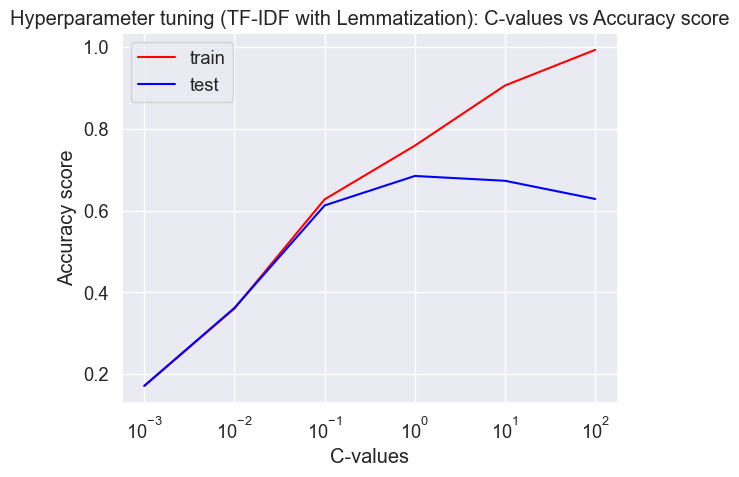

In [48]:
# The C_values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Empty lists to append train and test accuracy scores to
train_acc_hyper_lem = []
test_acc_hyper_lem = []

# Loop through the different C values
for C in C_values:

    # Instantiate the model, increase max_iter to 1000
    logit_lem = LogisticRegression(C=C, random_state=42, max_iter=1000)

    # Fit the model
    logit_lem.fit(X_train_tfidf_lem, y_train)

    # Score the model
    train_acc_hyper_lem.append(logit_lem.score(X_train_tfidf_lem, y_train))
    test_acc_hyper_lem.append(logit_lem.score(X_test_tfidf_lem, y_test))

# Create a plot to visualize hyperparameter tuning
plt.figure()
plt.plot(C_values, train_acc_hyper_lem, c='red', label='train')
plt.plot(C_values, test_acc_hyper_lem, c='blue', label='test')
plt.xscale('log')
plt.xlabel('C-values')
plt.ylabel('Accuracy score')
plt.title('Hyperparameter tuning (TF-IDF with Lemmatization): C-values vs Accuracy score')
plt.legend()
plt.show()

This is very similar to what we got with TF-IDF Stemming tokenizer. So, the best model fit is obtained with C=1 for both Stemming and Lemmatization. Now that, we have our best C value (c=1), let's explore "one vs rest" and "multinomial" approaches as ours is a multi-class problem. 

#### GridsearchCV for OVR vs multinomial stratgeies using our best C (c=1)

In [25]:
# Define the hyperparameter grid for multi_class and other hyperparameters
param_grid = {
    'multi_class': ['ovr', 'multinomial'],
    'C': [1]
}

# Create the logistic regression model
logit_lem = LogisticRegression(max_iter=1000, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(logit_lem, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to your data
grid_search.fit(X_train_tfidf_lem, y_train)

# Print the best parameters and corresponding accuracy score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Get the best classifier
best_classifier = grid_search.best_estimator_

# Use the best classifier for predictions
y_pred = best_classifier.predict(X_test_tfidf_lem)

# Training and test score
print(f"Train score (TF-IDF Lemmatization): {best_classifier.score(X_train_tfidf_lem, y_train)}")
print(f"Test score (TF-IDF Lemmatization): {best_classifier.score(X_test_tfidf_lem, y_test)}")

Best Parameters: {'C': 1, 'multi_class': 'multinomial'}
Best Accuracy: 0.6745916754478398
Train score (TF-IDF Lemmatization): 0.7586801896733404
Test score (TF-IDF Lemmatization): 0.6845446642606886


### Addressing class imbalance

Finally, let's try couple of methods to balance class imbalance using the current best model. 

- Set Class weight = 'balanced'
- SMOTE - Synthetic Minority Over-sampling Technique.

#### Class weight = 'balanced' with TF-IDF using custom tokenizer - Lemmatization

In [50]:
# logistic regression with "BALANCED" class weights
classifier_lem = LogisticRegression(max_iter=1000, class_weight='balanced')

classifier_lem.fit(X_train_tfidf_lem, y_train)

# Predictions for X_test
y_pred_lem = classifier_lem.predict(X_test_tfidf_lem)

# Training and test score
print(f"Train score (TF-IDF with Lemmatization): {classifier_lem.score(X_train_tfidf_lem, y_train)}")
print(f"Test score (TF-IDF with Lemmatization): {classifier_lem.score(X_test_tfidf_lem, y_test)}")

# Calculate accuracy and other metrics
accuracy_lem = accuracy_score(y_test, y_pred_lem)
classification_rep_lem = classification_report(y_test, y_pred_lem)

# Print the results
print("Accuracy (TF-IDF with Lemmatization):", accuracy_lem)
print("\nClassification Report (TF-IDF with Lemmatization):\n", classification_rep_lem)


Train score (TF-IDF with Lemmatization): 0.7391859852476291
Test score (TF-IDF with Lemmatization): 0.6533547588314322
Accuracy (TF-IDF with Lemmatization): 0.6533547588314322

Classification Report (TF-IDF with Lemmatization):
               precision    recall  f1-score   support

           0       0.41      0.63      0.49       653
           1       0.52      0.62      0.56      1378
           2       0.45      0.59      0.51       928
           3       0.39      0.72      0.51       566
           4       0.36      0.69      0.47       365
           5       0.70      0.58      0.64      3436
           6       0.42      0.67      0.52       697
           7       0.75      0.82      0.78      1654
           8       0.66      0.54      0.59      2161
           9       0.68      0.77      0.72       863
          10       0.19      0.40      0.26       416
          11       0.71      0.69      0.70      2469
          12       0.86      0.65      0.74      6488
          13  

In this scenario, our model's overall accuracy has seen a slight decrease, but there is an improvement in some of the individual category's F1 scores. For instance, consider the Education category, which has relatively low support (365 instances); its F1 score has increased from 0.43 to 0.47.

However, it's important to note that our domain doesn't face severe consequences from false positives and false negatives, compared to critical fields like medicine. Therefore, we can prioritize overall model accuracy and proceed without the need for the class_weight parameter set to 'balanced' from this point onward. 

#### SMOTE with TF-IDF using custom tokenizer - Lemmatization

In [51]:
# Initialize SMOTE for over-sampling
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample the training data using SMOTE
X_train_resampled_lem, y_train_resampled = smote.fit_resample(X_train_tfidf_lem, y_train)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier on the training data
classifier.fit(X_train_resampled_lem, y_train_resampled)

# Make predictions on the test data
y_pred = classifier.predict(X_test_tfidf_lem)

# Training and test score
print(f"Train score (tf_idf_lem): {classifier.score(X_train_resampled_lem, y_train_resampled)}")
print(f"Test score (tf_idf_lem): {classifier.score(X_test_tfidf_lem, y_test)}")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)

Train score (tf_idf_lem): 0.9106374705750476
Test score (tf_idf_lem): 0.66570954400569
Accuracy: 0.66570954400569

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.57      0.49       653
           1       0.53      0.62      0.57      1378
           2       0.43      0.57      0.49       928
           3       0.45      0.66      0.53       566
           4       0.42      0.62      0.50       365
           5       0.68      0.61      0.64      3436
           6       0.46      0.61      0.53       697
           7       0.77      0.81      0.79      1654
           8       0.64      0.58      0.61      2161
           9       0.71      0.76      0.73       863
          10       0.21      0.35      0.26       416
          11       0.70      0.70      0.70      2469
          12       0.84      0.70      0.76      6488
          13       0.40      0.57      0.47       376
          14       0.44      0.57      0.50       

SMOTE technique didn't yield substantial improvements in our model's performance. Despite achieving a high training accuracy of 91%, the test accuracy remained at 66.5%. So, we will not proceed with SMOTE for now.

### Word Embedding Techniques
Finally, we will explore sentence2vec embedding technique and try to capture the semantics of our article_text using pre-trained model: "word2vec-google-news-300". I have selected this specific word2vec model because it was trained on a large collection of news dataset (about 100 billion words) from Google, so the learnings from that might be appropriate for our case.

#### TF-IDF + Applying Sentence2Vec using word2vec-google-news-300

In [52]:
# Sanity check on input variable (X)
X.head()

1    Over 4 Million Americans Roll Up Sleeves For O...
2    American Airlines Flyer Charged, Banned For Li...
3    23 Of The Funniest Tweets About Cats And Dogs ...
4    The Funniest Tweets From Parents This Week (Se...
5    Woman Who Called Cops On Black Bird-Watcher Lo...
Name: article_text, dtype: object

In [53]:
# Embed article_text using 'word2vec-google-news-300' defined in custom sentence2vec function
X_emb = X.apply(sentence2vec)

In [54]:
# Shape after embedding
X_emb.shape

(189801,)

In [55]:
# Shifting X_emb to dense vector
X_emb=np.array(X_emb.tolist())

In [56]:
# Shape after changing it into an array
X_emb.shape

(189801, 300)

In [57]:
# Train/Test split based on embedded X. Add '_emb' to ease readability.
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, y, test_size=0.2, random_state=42, stratify=y
)

In [58]:
# Instantiate logistic regression
classifier = LogisticRegression(max_iter=1000)

# Train on the training data
classifier.fit(X_train_emb, y_train_emb)

y_pred_emb = classifier.predict(X_test_emb)

# Training and test score
print(f"Train score: {classifier.score(X_train_emb, y_train_emb)}")
print(f"Test score: {classifier.score(X_test_emb, y_test_emb)}")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_emb, y_pred_emb)
classification_rep = classification_report(y_test_emb, y_pred_emb)
confusion_mat = confusion_matrix(y_test_emb, y_pred_emb)

# Print the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)

Train score: 0.6364265015806112
Test score: 0.6334922683807065
Accuracy: 0.6334922683807065

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.36      0.43       653
           1       0.54      0.49      0.52      1378
           2       0.44      0.21      0.28       928
           3       0.53      0.44      0.48       566
           4       0.51      0.33      0.40       365
           5       0.55      0.62      0.58      3436
           6       0.50      0.36      0.42       697
           7       0.78      0.79      0.79      1654
           8       0.54      0.43      0.48      2161
           9       0.72      0.62      0.67       863
          10       0.42      0.08      0.13       416
          11       0.61      0.70      0.65      2469
          12       0.69      0.80      0.74      6488
          13       0.56      0.36      0.43       376
          14       0.58      0.43      0.50       780
          15      

The train and test accuracies are really close at 63% and there is a scope for us to analyze if the hyperparameters tuning will help improve model performance.

### Hyperparameter tuning on sentence2vec embedding

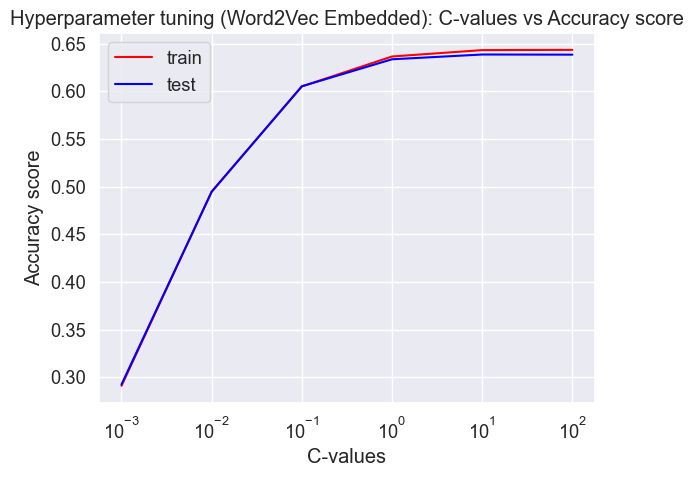

Accuracy: 0.6383393482784964

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.40      0.46       653
           1       0.54      0.49      0.52      1378
           2       0.45      0.24      0.32       928
           3       0.52      0.47      0.50       566
           4       0.49      0.38      0.43       365
           5       0.56      0.61      0.58      3436
           6       0.50      0.39      0.43       697
           7       0.78      0.78      0.78      1654
           8       0.54      0.44      0.49      2161
           9       0.71      0.66      0.69       863
          10       0.30      0.10      0.15       416
          11       0.62      0.69      0.65      2469
          12       0.70      0.79      0.74      6488
          13       0.52      0.41      0.46       376
          14       0.58      0.47      0.52       780
          15       0.68      0.61      0.65       883
          16       0.73    

In [59]:
# The C_values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Empty lists to append train and test accuracy scores to
train_acc_hyper_emb = []
test_acc_hyper_emb = []

# Loop through the different C values
for C in C_values:

    # Instantiate logistic regression
    classifier = LogisticRegression(C=C, max_iter=1000, random_state=42)

    # Train on the training data
    classifier.fit(X_train_emb, y_train_emb)

    # Predict on the test data
    y_pred_emb = classifier.predict(X_test_emb)

    # Append accuracy scores
    train_acc_hyper_emb.append(classifier.score(X_train_emb, y_train_emb))
    test_acc_hyper_emb.append(classifier.score(X_test_emb, y_test_emb))

# Create a plot to visualize hyperparameter tuning
plt.figure()
plt.plot(C_values, train_acc_hyper_emb, c='red', label='train')
plt.plot(C_values, test_acc_hyper_emb, c='blue', label='test')
plt.xscale('log')
plt.xlabel('C-values')
plt.ylabel('Accuracy score')
plt.title('Hyperparameter tuning (Word2Vec Embedded): C-values vs Accuracy score')
plt.legend()
plt.show()

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_emb, y_pred_emb)
classification_rep = classification_report(y_test_emb, y_pred_emb)
confusion_mat = confusion_matrix(y_test_emb, y_pred_emb)

# Print the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)


The model is really robust with very minimal change in accuracies after C=0.1 and the accuracies ranges between 60-65%. 

After an extensive exploration of different models and rigorous optimization of hyperparameters for logistic regression, our current best-performing model utilizes TF-IDF with custom tokenization methods such as Lemmatization and Stemming. This model consistently achieves approximately 68.5% accuracy on our test data. Our next step is to delve into our second classification model, which is the Naive-Bayes Classifier.

## Naive-Bayes Classifier

This classification algorithm relies on Bayesian statistics. In simple terms, it analyzes the features and learns patterns to determine the probability that a given word, such as 'tennis,' belongs to a specific class, like 'sports.'

Our exploration begins with Multinomial Naive Bayes, which is suitable for categorical features. 

**Note**: We will be using TF-IDF lemmatized tokens as X in our modeling.

### Multinomial Naive Bayes

In [21]:
# Initialize MultinomialNB classifier
multinomial_nb = MultinomialNB()

# Train the classifier on the TF-IDF lemmatized data
multinomial_nb.fit(X_train_tfidf_lem, y_train)

# Make predictions on the test data
y_pred = multinomial_nb.predict(X_test_tfidf_lem)

# Training and test score
print(f"Train score (TF-IDF Lemmatization): {multinomial_nb.score(X_train_tfidf_lem, y_train)}")
print(f"Test score (TF-IDF Lemmatization): {multinomial_nb.score(X_test_tfidf_lem, y_test)}")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)

Train score (TF-IDF Lemmatization): 0.6504017386722866
Test score (TF-IDF Lemmatization): 0.609915439530044
Accuracy: 0.609915439530044

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.10      0.17       653
           1       0.70      0.32      0.44      1378
           2       0.84      0.15      0.26       928
           3       0.70      0.11      0.19       566
           4       0.38      0.01      0.02       365
           5       0.53      0.73      0.61      3436
           6       0.77      0.11      0.20       697
           7       0.81      0.73      0.77      1654
           8       0.70      0.39      0.50      2161
           9       0.95      0.38      0.55       863
          10       0.00      0.00      0.00       416
          11       0.61      0.62      0.62      2469
          12       0.61      0.90      0.72      6488
          13       0.85      0.05      0.09       376
          14       0.93     

C:\Users\adhit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adhit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adhit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our initial implementation of vanilla Multinomial Naive Bayes classifier, yielded a training accuracy of 65.04% and a test accuracy of 60.99%. While this performance is good, it doesn't quite match the 68.5% accuracy achieved by our Logistic Regression model.

However, we can further explore another Naive-Bayes classifier - ComplementNB() - which is particularly suited for imbalanced datasets like ours.

### Complement Naive-Bayes

In [60]:
# Intial time
start_time = time.time()

# Initialize ComplementNB classifier
complement_nb = ComplementNB()
complement_nb.fit(X_train_tfidf_lem, y_train)
y_pred = complement_nb.predict(X_test_tfidf_lem)

# final and execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Print train and test scores
print(f"Train score (TF-IDF Lemmatization): {complement_nb.score(X_train_tfidf_lem, y_train)}")
print(f"Test score (TF-IDF Lemmatization): {complement_nb.score(X_test_tfidf_lem, y_test)}")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nClassification Report:\n", classification_rep)


Execution time: 0.17 seconds
Train score (TF-IDF Lemmatization): 0.6944217597471022
Test score (TF-IDF Lemmatization): 0.6624693764653197

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.36      0.48       653
           1       0.63      0.45      0.53      1378
           2       0.70      0.32      0.44       928
           3       0.54      0.39      0.45       566
           4       0.54      0.26      0.35       365
           5       0.63      0.66      0.65      3436
           6       0.56      0.38      0.45       697
           7       0.67      0.85      0.75      1654
           8       0.72      0.48      0.58      2161
           9       0.76      0.58      0.66       863
          10       0.62      0.04      0.07       416
          11       0.65      0.67      0.66      2469
          12       0.69      0.86      0.76      6488
          13       0.63      0.34      0.44       376
          14       0.68   

Our ComplementNB() model performs significantly better than our MultinomialNB() model. It achieves a high training accuracy of 69.44% and an impressive test accuracy of 66.25%. This highlights its strong performance, particularly in handling class imbalance. Since the results are promising, let's do hyper-paramter tuning to see if there is any further improvement in our model performance.

### Grid search on complementNB()

In [22]:
#Grid serach on complementNB()
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0]}
grid_search = GridSearchCV(ComplementNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf_lem, y_train)

best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Accuracy: {best_score}")


Best Alpha: 1.0
Best Cross-Validation Accuracy: 0.6581203898840885


The optimal result is obtained for alpha=1, which is our default setting for ComplementNB(). It yielded an overall cross-validation accuracy of 65.8% which is really good as well. The impressive aspect about this classifier is its ability to achieve a decent level of accuracy with shorter computation time. It strikes a fine balance between performance and computation.

After completing an exhaustive analysis using Naive Bayes, let's proceed to explore our next model - the Support Vector Classifier, also known as Support Vector Machines.

## Support Vector Classifier

SVMs involves identifying a linear classifier that maximizes the separation between its decision boundary and the data points. The key essence is that this additional margin serves to handle potential variations in the test data effectively. 

### LinearSVC

In [61]:
# Start time
start_time = time.time()

# LinearSVC 
classifier = LinearSVC()

# Training
classifier.fit(X_train_tfidf_lem, y_train)

# Print score
print(f"Kernel SVM score (train): {classifier.score(X_train_tfidf_lem, y_train)}")
print(f"Kernel SVM score (test): {classifier.score(X_test_tfidf_lem, y_test)}")

# Print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Kernel SVM score (train): 0.8858930453108536
Kernel SVM score (test): 0.6810147256394721
Execution time: 16.89 seconds


The initial outcome of the Vanilla LinearSVC appears encouraging, with a test accuracy of 68.10%. However, it's worth noting that the model shows signs of overfitting. Also, we will keep in mind the time it took for building LinearSVC (**16.89 seconds**) just to compare it with advance SVM(kernel trick) where the algorithm is complex. We can now proceed to optimize our hyperparameters and assess whether we can achieve overall performance enhancements.

### Hyper-parameter tuning on LinearSVC

C:\Users\adhit\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


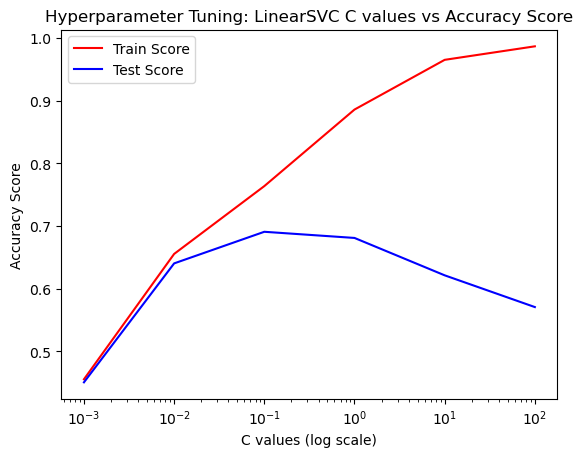

In [31]:
# C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# empty lists to store train and test scores
train_scores = []
test_scores = []

# Loop c values
for C in C_values:
    # Create a LinearSVC classifier with the current C value
    classifier = LinearSVC(C=C, random_state=42, max_iter=1000)

    # Train the classifier on the TF-IDF Lemmatization features
    classifier.fit(X_train_tfidf_lem, y_train)

    # Calculate and record the train and test scores
    train_score = classifier.score(X_train_tfidf_lem, y_train)
    test_score = classifier.score(X_test_tfidf_lem, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

# Create a plot to visualize the impact of C on train and test scores
plt.figure()
plt.plot(C_values, train_scores, c='red', label='Train Score')
plt.plot(C_values, test_scores, c='blue', label='Test Score')
plt.xscale('log')
plt.xlabel('C values (log scale)')
plt.ylabel('Accuracy Score')
plt.title('Hyperparameter Tuning: LinearSVC C values vs Accuracy Score')
plt.legend()
plt.show()

It looks like the model begins to overfit between C=0.01 and C=0.1. We can try another round of hyperparameter tuning using GridSearchCV().

### Gridsearch on LinearSVC 
- C 
- Class_weight and 
- Penalty

In [34]:
param_grid = {
    'C': [0.01, 0.03, 0.05, 0.07, 0.1],  
    'class_weight': [None, 'balanced'],
    'penalty': ['l2'] 
}

classifier = LinearSVC(max_iter=1000)

grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_tfidf_lem, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
Best Accuracy: 0.683627502634352


After conducting a grid search, we identified that the best model configuration is with C=0.1, 'class_weight' set to None, and 'penalty' set to 'l2'. Although there's a slight issue of overfitting, we'll now proceed to assess the training and testing accuracy using these optimized parameters.

In [38]:


classifier = LinearSVC(C=0.1, class_weight=None, penalty='l2')

classifier.fit(X_train_tfidf_lem, y_train)

print(f"Kernel SVM score (train): {classifier.score(X_train_tfidf_lem, y_train)}")
print(f"Kernel SVM score (test): {classifier.score(X_test_tfidf_lem, y_test)}")

Kernel SVM score (train): 0.7637381454162276
Kernel SVM score (test): 0.690840599562709


After fine-tuning the hyper-parmeters, we managed to get really good results. The training accuracy is 76.3%, and the testing accuracy is 69.08%. We will consider this model in our final evaluation to determine the best overall option.

Finally, we will also explore SVC(kernel='linear'), which also seeks a linear decision boundary but is computationally heavy due to the way the algorithm works, yet it has the potential for improved performance.

### SVC (linear kernel)

In [15]:
C = 1

# Start time
start_time = time.time()

# SVC lineark kernel with C=1
svc_classifier = SVC(kernel='linear', C=C, random_state=42)

svc_classifier.fit(X_train_tfidf_lem, y_train)

# Calculate accuracy scores
train_acc = svc_classifier.score(X_train_tfidf_lem, y_train)
test_acc = svc_classifier.score(X_test_tfidf_lem, y_test)

# Stop and execution times
end_time = time.time()
execution_time = end_time - start_time

# Results
print("Train Accuracy:", train_acc)
print("\nTest Accuracy:", test_acc)
print("\nExecution Time:", execution_time, "seconds")


Train Accuracy: 0.8183811907270812

Test Accuracy:
 0.6872316324648982

Execution Time: 5633.644542694092 seconds


The model's outcome resulted in a training accuracy of 81.8% and a testing accuracy of 68.7%, indicating a significant degree of overfitting. Furthermore, **the model required over 90 minutes to complete a single iteration**, which can be attributed to the algorithm's complex higher-order computations when **compared to LinearSVC, which only took 16.89 seconds**.

Now that we have developed several models and variations, let's proceed to compare their performances and choose the one that best aligns with our business requirements

## Model Evaluations and Selection

### Evaluation Metric: Accuracy vs. F1 Score
Within our business context, accuracy remains relevant as misclassifying target labels may be acceptable, given that it's not of utmost importance. Hence, we can certainly consider integrating the F1 score into our project's future scope, with the objective being the reduction of misclassifications between categories.

In the following table, we present a comprehensive evaluation of various models along with their respective tokenization techniques and preprocessing variations. The table includes training and testing accuracies as well as remarks to provide insights into the performance of each model in our analysis.

|     Model           |   Tokenizer         |  Pre-processing / Variation      |       |  Train  |  Test  |  Remarks         |
|:-------------------:|:-------------------:|:--------------------------------:|-------|:-------:|:------:|:----------------:|
| **Logistic Regression** |  CountVectorizer  |       Lemmatization              |       |   90%   |   66%  |    Overfitting   |
|                     |                    |            Stemming               |       |   90%   |   67%  |    Overfitting   |
|                     |        TF-IDF       |       Lemmatization              |       |   75%   |   68%  | <font color="green"><b>High Test accuracy</b></font> |
|                     |                    |            Stemming               |       |   75%   |   68%  | <font color="green"><b>High Test accuracy</b></font> |
|       |         |     Class_weight='balanced' / Lemmatization |             |74%                |   65%  | <font color="green"><b>Promising</b></font>    |
|        |         |    SMOTE / Lemmatization |  |             91%                |   67%   |    Overfitting   |
|                    | |    Sentence2Vec     |   |            64%                |   63%   | <font color="green"><b>Promising</b></font>    |
| **Naïve Bayes**     |        TF-IDF       | MultinomialNB() / Lemmatization  |       |   65%   |   61%  | <font color="green"><b>Promising</b></font>    |
|                     |                    | ComplementNB() / Lemmatization   |       |   69%   |   66%  | <font color="green"><b>Promising</b></font>    |
| **Support Vector Machines** |    TF-IDF   |  LinearSVC / Lemmatization       |       |   89%   |   68%  |    Overfitting   |
|                     |                    | SVC(kernel='linear') / Lemmatization || 82%  |   69%  | Overfitting / Computation heavy |


### Model Selection
Among the 11 different outcomes we obtained from our model-building exercise, 6 of them are promising. However, the model generated from Logistic Regression using TF-IDF (Lemmatization/Stemming) not only achieved the highest test accuracy but also facilitated result interpretation. With 75% train and 68% test accuracies, our model strikes a reasonable balance between bias and variance trade-offs. 

## Summary

In summary, we conducted an in-depth exploration of three distinct classification models, initially starting with basic vanilla models and subsequently fine-tuning them to assess the impact of hyperparameters on model performance. Additionally, we scrutinized our model evaluation procedures, justifying our choice of accuracy as the primary metric. We compared all 11 variations in terms of their training and testing accuracies, ultimately selecting Logistic Regression as our preferred model for our business case.

Finally, we successfully deployed our model using a Streamlit app, showcasing the capabilities of our machine learning model. Our final product has the potential to benefit advertisers, publishers, and digital users alike, offering an alternative approach to displaying creative ads without relying on tracking user behavior through third-party cookies.